# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 4 - Regularization 



**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">

### INSTRUCTIONS

- **This homework must be completed individually.**

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.


Names of people you have worked with goes here: 

<hr style="height:2pt">

In [85]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import these libraries

In [86]:
import warnings
#warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

from pandas.core import datetools
%matplotlib inline

# Continuing Bike Sharing Usage Data

In this homework, we will focus on regularization and cross validation. We will continue to build regression models for the [Capital Bikeshare program](https://www.capitalbikeshare.com) in Washington D.C.  See homework 3 for more information about the Capital Bikeshare data that we'll be using extensively. 



<div class='exercise'> <b> Question 1 [20pts]  Data pre-processing </b> </div>

**1.1** Read in the provided `bikes_student.csv` to a data frame named `bikes_main`. Split it into a training set `bikes_train` and a validation set `bikes_val`. Use `random_state=90`, a test set size of .2, and stratify on month. Remember to specify the data's index column as you read it in.

**1.2** As with last homework, the response will be the `counts` column and we'll drop `counts`, `registered` and `casual` for being trivial predictors, drop `workingday` and `month` for being multicollinear with other columns, and `dteday` for being inappropriate for regression. Write code to do this.

Encapsulate this process as a function with appropriate inputs and outputs, and **test** your code by producing `practice_y_train` and `practice_X_train`.

**1.3** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns in your `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns, including the polynomial columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`


**1.4** Write a code to augment your a dataset with higher-order features for `temp`, `atemp`, `hum`,`windspeed`, and `hour`. You should include ONLY the pure powers of these columns. So with degree=2 you should produce `atemp^2` and `hum^2` but not `atemp*hum` or any other two-feature interactions. 


Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with quadratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

**1.5** Write code to add interaction terms to the model. Specifically, we want interactions between the continuous predictors (`temp`,`atemp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `atemp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a continuous feature times a weekday dummy.


Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**

**1.6** Combine all your code so far into a function that takes in `bikes_train`, `bikes_val`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_val` and responses `y_train` and `y_val`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.



### Solutions 

**1.1** Read in the provided `bikes_student.csv` to a data frame named `bikes_main`. Split it into a training set `bikes_train` and a validation set `bikes_val`. Use `random_state=90`, a test set size of .2, and stratify on month. Remember to specify the data's index column as you read it in.

In [88]:
# read in the data
bikes_main = pd.read_csv('./data/bikes_student.csv', index_col= 0)
bikes_main.head()

,dteday,hour,year,holiday,workingday,temp,atemp,hum,windspeed,casual,...,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm,month
5887,2011-09-07,19,0,0,1,0.64,0.5758,0.89,0.0000,14,...,0,0,1,0,0,0,1,0,0,9
10558,2012-03-21,1,1,0,1,0.52,0.5000,0.83,0.0896,4,...,0,0,1,0,0,0,0,0,0,3
14130,2012-08-16,23,1,0,1,0.70,0.6515,0.54,0.1045,58,...,0,0,0,1,0,0,0,0,0,8
2727,2011-04-28,13,0,0,1,0.62,0.5758,0.83,0.2985,18,...,0,0,0,1,0,0,1,0,0,4
8716,2012-01-04,0,1,0,1,0.08,0.0606,0.42,0.3284,0,...,0,0,1,0,0,0,0,0,0,1


In [89]:
print(bikes_main.columns)

Index(['dteday', 'hour', 'year', 'holiday', 'workingday', 'temp', 'atemp',
       'hum', 'windspeed', 'casual', 'registered', 'counts', 'Feb', 'Mar',
       'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec',
       'spring', 'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm', 'month'],
      dtype='object')


In [90]:
bikes_train, bikes_val = train_test_split(bikes_main, 
                                          random_state=90, 
                                          test_size = 0.2, 
                                          stratify = bikes_main.month)

**1.2** As with last homework, the response will be the `counts` column and we'll drop `counts`, `registered` and `casual` for being trivial predictors, drop `workingday` and `month` for being multicolinear with other columns, and `dteday` for being inappropriate for regression. Write code to do this.

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_y_train` and `practice_X_train`


In [91]:
# your code here
def get_X_and_y(df, response_column, columns_to_drop):
    response_column = ['counts']
    columns_to_drop = ['counts', 'registered', 'casual','workingday','month','dteday']
    
    df_X = df.drop(columns_to_drop, axis = 1)
    df_y = df[response_column]
    
    return df_X, df_y

In [92]:
response_column = ['counts']
columns_to_drop = ['counts', 'registered', 'casual','workingday','month','dteday']
practice_X_train, practice_y_train = get_X_and_y(bikes_train, response_column, columns_to_drop)

In [93]:
print(practice_X_train.columns)

Index(['hour', 'year', 'holiday', 'temp', 'atemp', 'hum', 'windspeed', 'Feb',
       'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec',
       'spring', 'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm'],
      dtype='object')


In [94]:
print(practice_y_train.columns)

Index(['counts'], dtype='object')


**1.3** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns in your `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns, including the polynomial columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`


In [102]:
# your code here
def scale_col(df_to_scale, df_train, col_to_scale):
    df = df_to_scale.copy()
    for col in df:
        if col in col_to_scale:
            df[col] = (df[col] - df_train[col].mean())/df_train[col].std()
    
    #standardize columns
    return df

In [103]:
binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']
non_binary_columns = practice_X_train.columns.difference(binary_columns)
practice_X_train_scaled  = scale_col(practice_X_train, practice_X_train, non_binary_columns)
practice_X_train_scaled.describe()

,hour,year,holiday,temp,atemp,hum,windspeed,Feb,Mar,Apr,...,fall,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
count,1.000000e+03,1.000000e+03,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.0
mean,-1.278977e-16,-4.973799e-17,0.027000,5.329071e-17,-1.101341e-16,1.136868e-16,8.881784e-17,0.078000,0.085000,0.082000,...,0.248000,0.143000,0.148000,0.162000,0.128000,0.12700,0.15000,0.280000,0.082000,0.0
std,1.000000e+00,1.000000e+00,0.162164,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.268306,0.279021,0.274502,...,0.432068,0.350248,0.355278,0.368635,0.334257,0.33314,0.35725,0.449224,0.274502,0.0
min,-1.645340e+00,-1.017656e+00,0.000000,-2.346801e+00,-2.401403e+00,-3.395903e+00,-1.553427e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.0
25%,-9.185353e-01,-1.017656e+00,0.000000,-7.918731e-01,-8.117208e-01,-7.417755e-01,-7.227439e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.0
50%,-4.637012e-02,9.816679e-01,0.000000,3.742194e-02,7.143602e-02,5.446269e-02,-1.129730e-02,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.0
75%,8.257951e-01,9.816679e-01,0.000000,8.667170e-01,8.665686e-01,8.507009e-01,4.632654e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.0
max,1.697960e+00,9.816679e-01,1.000000,2.317983e+00,2.544858e+00,1.912352e+00,5.208893e+00,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,0.0


**1.4** Write a code to augment your a dataset with higher-order features for `temp`, `atemp`, `hum`,`windspeed`, and `hour`. You should include ONLY pure powers of these columns. So with degree=2 you should produce `atemp^2` and `hum^2` but not `atemp*hum` or any other two-feature interactions. 


Encapsulate this process as a function with apropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with qudratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

In [107]:
# your code here
def add_poly_columns(df, columns, degree, 
                     nonbinary_columns = ['atemp', 'hour', 'hum', 'temp', 'windspeed', 'year']):
    """
    df pandas DataFrame: the df to add polynomial terms to
    columns list(str): the list of columns for which to add polynomial terms
    degree int: add polynomials from 2 to this degree (inclusive). Interactions are not included.
    """
    df_poly = df.copy()
    for d in range(2, degree + 1):
        for col in columns:
            if col in nonbinary_columns:
                df_poly[col+'^'+str(d)] = df[col].apply(lambda x : x**d)
    return df_poly

In [108]:
columns = practice_X_train_scaled.columns
practice_X_train_poly = add_poly_columns(practice_X_train_scaled, columns, 3)
practice_X_train_poly.head()

,hour,year,holiday,temp,atemp,hum,windspeed,Feb,Mar,Apr,...,temp^2,atemp^2,hum^2,windspeed^2,hour^3,year^3,temp^3,atemp^3,hum^3,windspeed^3
15762,1.697960,0.981668,0,0.244746,0.248650,0.479123,-0.722744,0,0,0,...,0.059900,0.061827,0.229559,0.522359,4.895337,0.946006,0.014660,0.015373,0.109987,-0.377532
4213,-0.046370,-1.017656,0,1.385026,1.131807,-1.538014,0.226382,0,0,0,...,1.918298,1.280987,2.365486,0.051249,-0.000100,-1.053908,2.656894,1.449831,-3.638150,0.011602
14301,-1.354618,0.981668,0,0.866717,0.866569,0.266793,-1.553427,0,0,0,...,0.751198,0.750941,0.071178,2.413137,-2.485710,0.946006,0.651076,0.650742,0.018990,-3.748633
15900,-0.918535,0.981668,0,-0.999197,-0.988352,0.903783,-0.485860,0,0,0,...,0.998394,0.976840,0.816825,0.236060,-0.774975,0.946006,-0.997593,-0.965462,0.738233,-0.114692
14320,1.407239,0.981668,0,1.074041,1.043200,-0.157867,-0.248181,0,0,0,...,1.153564,1.088266,0.024922,0.061594,2.786783,0.946006,1.238974,1.135279,-0.003934,-0.015286


In [109]:
print(practice_X_train_poly.columns)

Index(['hour', 'year', 'holiday', 'temp', 'atemp', 'hum', 'windspeed', 'Feb',
       'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec',
       'spring', 'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm', 'hour^2', 'year^2', 'temp^2', 'atemp^2',
       'hum^2', 'windspeed^2', 'hour^3', 'year^3', 'temp^3', 'atemp^3',
       'hum^3', 'windspeed^3'],
      dtype='object')


**1.5** Write code to add interaction terms to the model. Specifically, we want interactions between the continuous predictors (`temp`,`atemp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `atemp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a continuous feature times a weekday dummy.


Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**


In [111]:
# your code here
def add_interaction_terms(df_to_add_interactions,
                          df_original,
                          continuous_columns = ['temp','atemp','hum','windspeed'],
                          dummy_columns = ['Feb', 'Mar', 'Apr','May', 'Jun', 'Jul',
                                           'Aug', 'Sept', 'Oct', 'Nov', 'Dec','Mon', 
                                           'Tue', 'Wed', 'Thu', 'Fri', 'Sat']):
    """
    df_to_add_interactions pandas DataFrame: dataframe to add interaction terms
    df_original pandas DataFrame: dataframe holding the terms to form interactions with
    continuous_columns list(str): names of continuous predictors
    dummy_columns: names of dummy predictors (0/1)
    """
    df_interact = df_to_add_interactions.copy()
    for cont_col in continuous_columns:
        for other_col in dummy_columns:
            if cont_col is not other_col:
                df_interact[cont_col+"*"+other_col] = df_original[cont_col]*df_original[other_col]
    return df_interact

In [112]:
practice_X_train_interact = add_interaction_terms(practice_X_train_poly, practice_X_train)

In [115]:
print([c for c in practice_X_train_interact.columns])

['hour', 'year', 'holiday', 'temp', 'atemp', 'hum', 'windspeed', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring', 'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm', 'hour^2', 'year^2', 'temp^2', 'atemp^2', 'hum^2', 'windspeed^2', 'hour^3', 'year^3', 'temp^3', 'atemp^3', 'hum^3', 'windspeed^3', 'temp*Feb', 'temp*Mar', 'temp*Apr', 'temp*May', 'temp*Jun', 'temp*Jul', 'temp*Aug', 'temp*Sept', 'temp*Oct', 'temp*Nov', 'temp*Dec', 'temp*Mon', 'temp*Tue', 'temp*Wed', 'temp*Thu', 'temp*Fri', 'temp*Sat', 'atemp*Feb', 'atemp*Mar', 'atemp*Apr', 'atemp*May', 'atemp*Jun', 'atemp*Jul', 'atemp*Aug', 'atemp*Sept', 'atemp*Oct', 'atemp*Nov', 'atemp*Dec', 'atemp*Mon', 'atemp*Tue', 'atemp*Wed', 'atemp*Thu', 'atemp*Fri', 'atemp*Sat', 'hum*Feb', 'hum*Mar', 'hum*Apr', 'hum*May', 'hum*Jun', 'hum*Jul', 'hum*Aug', 'hum*Sept', 'hum*Oct', 'hum*Nov', 'hum*Dec', 'hum*Mon', 'hum*Tue', 'hum*Wed', 'hum*Thu', 'hum*Fri', 'hum*Sat', 'windspeed*Feb'

In [116]:
practice_X_train_interact.head()

,hour,year,holiday,temp,atemp,hum,windspeed,Feb,Mar,Apr,...,windspeed*Sept,windspeed*Oct,windspeed*Nov,windspeed*Dec,windspeed*Mon,windspeed*Tue,windspeed*Wed,windspeed*Thu,windspeed*Fri,windspeed*Sat
15762,1.697960,0.981668,0,0.244746,0.248650,0.479123,-0.722744,0,0,0,...,0.0,0.1045,0.0,0.0,0.0,0.1045,0.0000,0.0,0.0000,0.0
4213,-0.046370,-1.017656,0,1.385026,1.131807,-1.538014,0.226382,0,0,0,...,0.0,0.0000,0.0,0.0,0.0,0.0000,0.2239,0.0,0.0000,0.0
14301,-1.354618,0.981668,0,0.866717,0.866569,0.266793,-1.553427,0,0,0,...,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0000,0.0
15900,-0.918535,0.981668,0,-0.999197,-0.988352,0.903783,-0.485860,0,0,0,...,0.0,0.1343,0.0,0.0,0.0,0.0000,0.1343,0.0,0.0000,0.0
14320,1.407239,0.981668,0,1.074041,1.043200,-0.157867,-0.248181,0,0,0,...,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.0,0.1642,0.0


**1.6** Combine all your code so far into a function that takes in `bikes_train`, `bikes_val`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_val` and responses `y_train` and `y_val`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.

In [55]:
def get_design_mats(train_df, val_df,  degree, 
                    columns_forpoly=['temp', 'atemp', 'hum','windspeed', 'hour'],
                    target_col='counts', 
                    bad_columns=['counts', 'registered', 'casual', 'workingday', 'month', 'dteday']):
    # add code here 
    
    # get predictors and target
    x_val,y_val = get_X_and_y(val_df, target_col, bad_columns)
    x_train,y_train = get_X_and_y(train_df, target_col, bad_columns)
    
    # scale columns
    x_val_scaled = scale_col(x_val, x_train, columns_forpoly)
    x_train_scaled = scale_col(x_train, x_train, columns_forpoly)
    
    # add polynomial terms
    x_val_poly = add_poly_columns(x_val_scaled, columns_forpoly, degree)
    x_train_poly = add_poly_columns(x_train_scaled, columns_forpoly, degree)
    
    # add interaction terms
    x_val_interact = add_interaction_terms(x_val_poly, x_val)
    x_train_interact = add_interaction_terms(x_train_poly, x_train)
    
    x_train, x_val = x_train_interact, x_val_interact
    
    return x_train,y_train, x_val,y_val

In [56]:
# your code here
x_train,y_train, x_val,y_val = get_design_mats(bikes_train, bikes_val,  3)

In [57]:
x_train.columns

Index(['hour', 'year', 'holiday', 'temp', 'atemp', 'hum', 'windspeed', 'Feb',
       'Mar', 'Apr',
       ...
       'windspeed*Sept', 'windspeed*Oct', 'windspeed*Nov', 'windspeed*Dec',
       'windspeed*Mon', 'windspeed*Tue', 'windspeed*Wed', 'windspeed*Thu',
       'windspeed*Fri', 'windspeed*Sat'],
      dtype='object', length=108)

In [58]:
y_train.columns

Index(['counts'], dtype='object')

In [59]:
x_val.columns

Index(['hour', 'year', 'holiday', 'temp', 'atemp', 'hum', 'windspeed', 'Feb',
       'Mar', 'Apr',
       ...
       'windspeed*Sept', 'windspeed*Oct', 'windspeed*Nov', 'windspeed*Dec',
       'windspeed*Mon', 'windspeed*Tue', 'windspeed*Wed', 'windspeed*Thu',
       'windspeed*Fri', 'windspeed*Sat'],
      dtype='object', length=108)

In [60]:
y_val.columns

Index(['counts'], dtype='object')

<div class='exercise'> <b> Question 2 [20pts]: Regularization via Ridge </b></div>

**2.1** For each degree in 1 through 8:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the validation data.

**2.2** Discuss patterns you see in the results from 2.1. Which model would you select, and why?

**2.3** Let's try regularizing our models via ridge regression. Build a table showing the validation set $R^2$ of polynomial models with degree from 1-8, regularized at the levels $\lambda = (.01, .05, .1,.5, 1, 5, 10, 50, 100)$. Do not perform cross validation at this point, simply report performance on the single validation set. 

**2.4** Find the best-scoring degree and regularization combination.

**2.5** It's time to see how well our selected model will do on future data. Read in the provided test dataset, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? 

**2.6** Why do you think our model's test score was quite a bit worse than its validation score? Does the test set simply contain harder examples, or is something else going on?

### Solutions 

**2.1** For each degree in 1 through 8:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the validation data.

Text(0.5,1,'The Best Performing Model is at Degree 8')

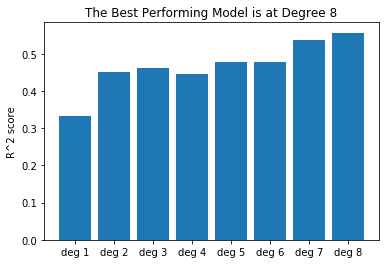

In [124]:
# your code here
scores = {}
for deg in range(1,9):
    x_train, y_train, x_val, y_val = get_design_mats(bikes_train, bikes_val,  deg)
    model = LinearRegression().fit(x_train, y_train)
    scores['deg ' + str(deg)] = model.score(x_val,y_val)
plt.bar(scores.keys(),scores.values())
plt.ylabel('R^2 score')
plt.title('The Best Performing Model is at Degree 8')

**2.2** Discuss patterns you see in the results from 2.1. Which model would you select, and why?**

*your answer here*

I would select the degree 8 model although, since this is the highest degree we tested, I would explore higher degree polynomials.

**2.3** Let's try regularizing our models via ridge regression. Build a table showing the validation set $R^2$ of polynomial models with degree from 1-8, regularized at the levels $\lambda = (.01, .05, .1,.5, 1, 5, 10, 50, 100)$. Do not perform cross validation at this point, simply report performance on the single validation set. 


In [174]:
# your code here
scores = {}
reg_param = [0.01, 0.05, .1,.5,1,5,10,50,100]
for deg in range(1,9):
    scores['deg_' + str(deg)] = []
    for reg in reg_param:
        x_train, y_train, x_val, y_val = get_design_mats(bikes_train, bikes_val,  deg)
        model = Ridge(alpha = reg).fit(x_train, y_train)
        scores['deg_' + str(deg)].append(model.score(x_val,y_val))
scores_df = pd.DataFrame(scores)

In [175]:
reg_param_str = [str(r) for r in reg_param]

Text(0.5,1,'The best model performance is achieved with \n degree = 8 and regularization parameter = .1')

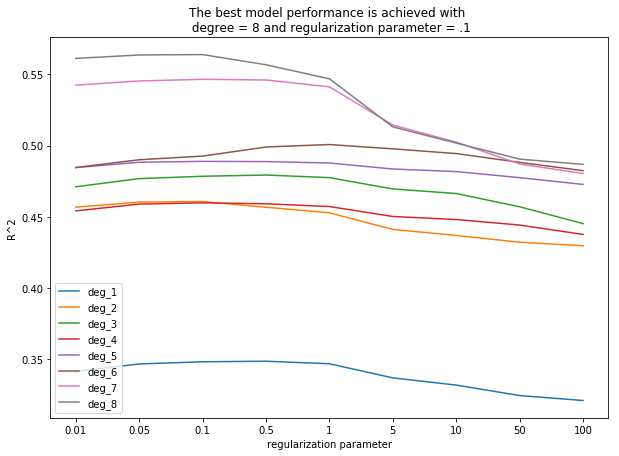

In [184]:
plt.figure(figsize = (10,7))
for col in scores_df:
    plt.plot(reg_param_str, scores_df[col], label = col)
plt.legend()
plt.xlabel('regularization parameter')
plt.ylabel('R^2')
plt.title("The best model performance is achieved with \n degree = 8 and regularization parameter = .1")

**2.4** Find the best-scoring degree and regularization combination.

In [188]:
# your code here
best_score = 0
best_degree = None
best_reg = None
for col in scores_df:
    for idx, param in enumerate(reg_param):
        if scores_df[col][idx] > best_score:
            best_score = scores_df[col][idx]
            best_degree = col
            best_reg = param
print("The best degree is {} and the best regularization parameter is {}".format(best_degree, best_reg))

The best degree is deg_8 and the best regularization parameter is 0.1


**2.5** It's time to see how well our selected model will do on future data. Read in the provided test dataset `data/bikes_test.csv`, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? 

In [67]:
# your code here
bikes_test = pd.read_csv('./data/bikes_test.csv', index_col= 0)
bikes_test.head()

,dteday,hour,year,holiday,workingday,temp,atemp,hum,windspeed,casual,...,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm,month
7955,2011-12-03,3,0,0,0,0.24,0.2424,0.70,0.1343,4,...,0,0,0,0,0,1,0,0,0,12
113,2011-01-05,22,0,0,1,0.18,0.1970,0.55,0.1343,1,...,0,0,1,0,0,0,0,0,0,1
701,2011-02-01,14,0,0,1,0.22,0.2576,0.80,0.0896,5,...,0,1,0,0,0,0,1,0,0,2
12221,2012-05-29,10,1,0,1,0.74,0.6970,0.70,0.2985,67,...,0,1,0,0,0,0,0,0,0,5
7255,2011-11-03,22,0,0,1,0.40,0.4091,0.82,0.0000,21,...,0,0,0,1,0,0,0,0,0,11


In [189]:
# set best params
best_deg = 8
best_reg_param = 0.01

# fit model
x_train, y_train, x_test, y_test = get_design_mats(bikes_main, bikes_test, best_deg)
model = Ridge(alpha = best_reg_param).fit(x_train, y_train)

#evaluate best model
print("R^2 score for best performing model on test set: ",model.score(x_test,y_test))

R^2 score for best performing model on test set:  0.5896762331536515


**2.6** Why do you think our model's test score was quite a bit worse than its validation score? Does the test set simply contain harder examples, or is something else going on?

*your answer here*
While in this case the test score was higher than the validation score, there are two reasons why this might occur.

* **Regression to the Mean:** The performance of any model is a combination of true predictive ability and luck. For every additional model you evaluate, the chance that the best performing model was chosen based on luck rather skill increases. While this model still may be the best, it's performance may regress towards the mean when evaluated on the test set.

* **Distributional Shift Between Train and Test Data:** If the distribution of our test data does not match the distribution of our training and validation data, then model performance may suffer. This could happen if the test data was generated over a different time period, was not a representative sample of the dataset, or by chance.

* **Overfitting the validation data** If you evaluate a number of models on the training set, you will begin to fit to the individual data points in the validation set and not the underlying data generating distribution. This will lead to a "best" model with high variance that may not perform well in general.

<div class='exercise'><b> Question 3 [20pts]: Comparing Ridge, Lasso, and OLS </b> </div>

**3.1** Build a dataset with polynomial degree 1 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `(.1,.5,1,5,10,50,100)`. 

Note: On the lasso model, you will need to increase `max_iter` to 100,000 for the optimization to converge.

**3.2** Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

**3.3** The plots above show the overall distribution of coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

**3.4** What trends do you see in the plot above? How do the three approaches handle the correlated pair `temp` and `atemp`?

### Solutions

**3.1** Build a dataset with polynomial degree 1 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `(.1,.5,1,5,10,50,100)`. 

Note: On the lasso model, you will need to increase `max_iter` to 100,000 for the optimization to converge.

In [70]:
#your code here
reg_param = [.1,.5,1,5,10,50,100]
x_train, y_train, x_test, y_test = get_design_mats(bikes_main, bikes_test, 1)
model_ols = LinearRegression().fit(x_train, y_train)
model_ridge = RidgeCV(alphas = reg_param).fit(x_train, y_train)
model_lasso = LassoCV(alphas = reg_param, max_iter = 100000).fit(x_train, y_train)

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



**3.2** Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


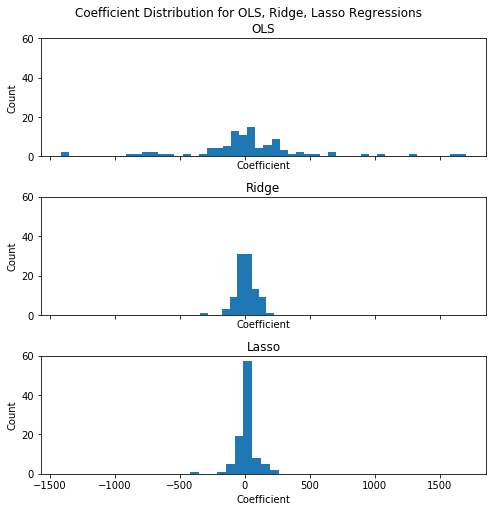

In [71]:
fig, axes = plt.subplots(3, 1, figsize=(7, 7), sharex=True, sharey = True)
models = [model_ols, model_ridge, model_lasso]
model_names = ['ols','ridge','lasso']
axes[0].hist(list(model_ols.coef_[0]),bins = 50)
axes[0].set_xlabel('Coefficient')
axes[0].set_ylabel('Count')
axes[0].set_title('OLS')

axes[1].hist(list(model_ridge.coef_[0]))
axes[1].set_xlabel('Coefficient')
axes[1].set_ylabel('Count')
axes[1].set_title('Ridge')

axes[2].hist(list(model_lasso.coef_))
axes[2].set_xlabel('Coefficient')
axes[2].set_ylabel('Count')
axes[2].set_title('Lasso')

fig.suptitle('Coefficient Distribution for OLS, Ridge, Lasso Regressions',y=1.01)
fig.tight_layout()
fig.show()

*your answer here*


Lasso and ridge both have a smaller range in their coefficient values when compared to OLS. Lasso has many more values equal to 0, while Ridge simply has smaller coefficient values.

**3.3** The plots above show the overall distribution of coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

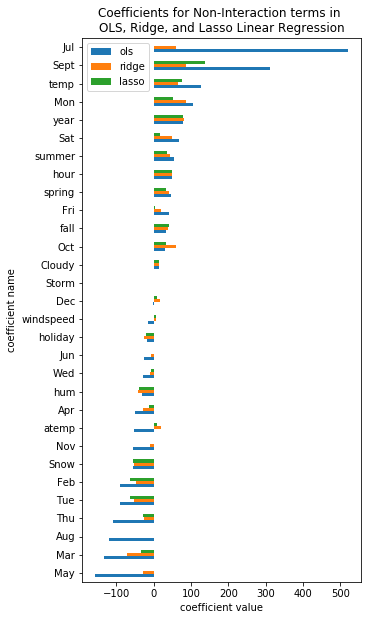

In [82]:
# your code here
df_coefs = pd.DataFrame({'ols': model_ols.coef_[0], 'ridge': model_ridge.coef_[0], 'lasso': model_lasso.coef_})
df_coefs.index = x_train.columns
non_interaction = [var_name for var_name in df_coefs.index if "*" not in var_name]
coef_plt = (df_coefs
            .loc[non_interaction]
            .sort_values(by='ols')
            .plot(kind = 'barh',
                  title = "Coefficients for Non-Interaction terms in \nOLS, Ridge, and Lasso Linear Regression",
                  figsize = (5,10)
                 )
           )
coef_plt.set_xlabel('coefficient value')
coef_plt.set_ylabel('coefficient name')
plt.show()

Text(0,0.5,'coefficient name')

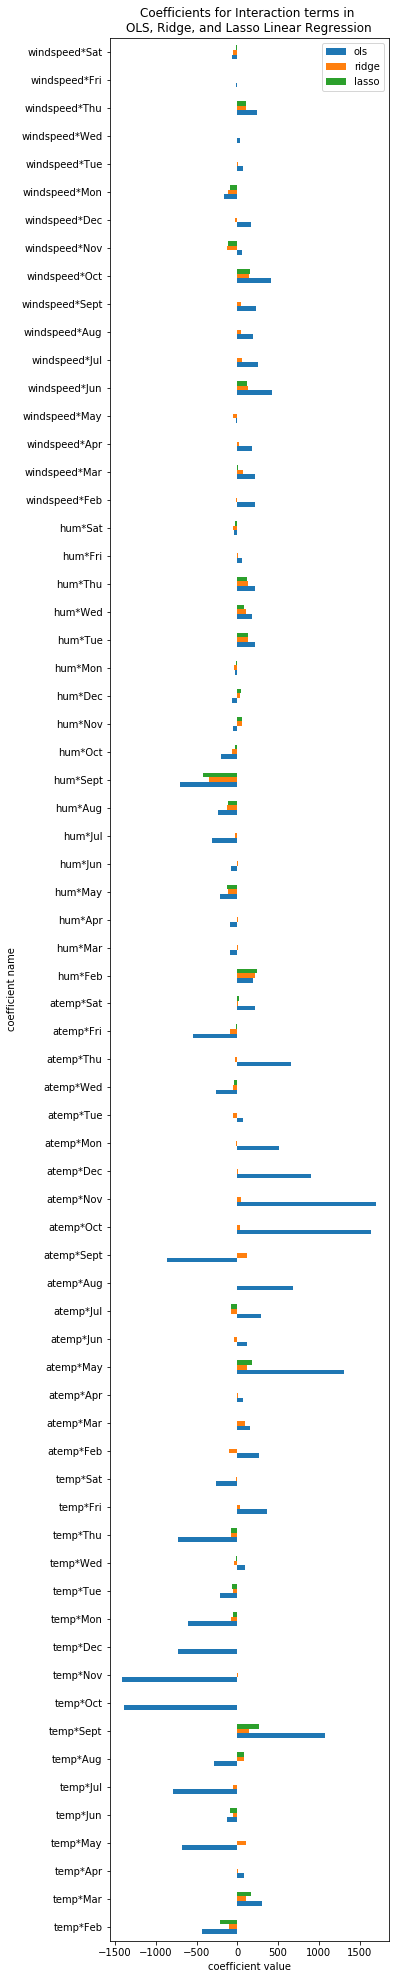

In [84]:
# your code here
interaction = [var_name for var_name in df_coefs.index if "*" in var_name]
coef_plt = (df_coefs
            .loc[interaction]
            .plot(kind = 'barh',
                  title = "Coefficients for Interaction terms in \nOLS, Ridge, and Lasso Linear Regression",
                  figsize = (5,35)
                 )
           )
coef_plt.set_xlabel('coefficient value')
coef_plt.set_ylabel('coefficient name')

**3.4** What trends do you see in the plot above? How do the three approaches handle the correlated pair `temp` and `atemp`?

*your answer here*

There is greater variance in the coefficients for the OLS regression as opposed to ridge and lasso. A contributing factor to the stability of ridge and lasso is that these methods better handle collinearities in the data. While OLS sets `temp` to a large positive value and `atemp` to a large negative value, ridge and lasso both set `temp` to a relatively large positive value but restrict `atemp` to small positive values. This occurs because, by discounting large parameter values, ridge and lasso are forced to be more efficient with the information provided. If `temp` and `atemp` are collinear, these regularized models will make the parameters for one of these covariates small in order to avoid encoding redundant information (and in the case of lasso, even nullify the coeffecient altogether).

<div class='exercise'> <b> Question 4 [20 pts]: Reflection </b></div>
These problems are open-ended, and you are not expected to write more than 2-3 sentences. We are interested in seeing that you have thought about these issues; you will be graded on how well you justify your conclusions here, not on what you conclude.

**4.1** Reflect back on the `get_design_mats` function you built. Writing this function useful in your analysis? What issues might you have encountered if you copy/pasted the model-building code instead of tying it together in a function? Does a `get_design_mat` function seem wise in general, or are there better options?

*your answer here*

Implementing the get_design matrix allows for greater reproducibility, clarity, and rhobustness:
* If someone wanted to reproduce my preprocessing steps, they would only have to look at this function. 
* It also makes it clear to someone reading my code what preprocessing steps I took. 
* Finally, if I want to iterate on my preprocessing steps, it ensures that I am applying the same methods to my training, validation, and test sets. If we apply different preprocessing steps in training, validation, and testing, we may get innacurate results or errors.

Implementing a `get_design_mat` function is wise in general. However, if we want to compare different preprocessing and modelling combinations, one might need to implement multiple preprocessing functions, which could be stored in a list or another more advanced data structure as needed. Additionally, if we wanted to encapsulate the preprocessing and model into a single data structure, one might want to implement a class.

**4.2** What are the costs and benefits of applying ridge/lasso regularization to an overfit OLS model, versus setting a specific degree of polynomial or forward selecting features for the model?

*your answer here*

**benefits:** 
* The benefit of using ridge/lasso regularization over setting a specific degree polynomial is that it doesn't require us to know the ideal degree beforehand, which might be difficult to discover.  
* The benefit of using ridge/lasso regularization over forward selection is that it regularizes all the freatures simultaneously, while foward selection does a greedy search
* Lasso and ridge can handle the case when p > n 
* Ridge/Lasso might lead to more accurate predictions than forward selection because they can adjust the weights of the covariates instead of making a binary decision to include or not. This applies more to ridge than lasso since lasso tends to set coeffecients to 0.

**costs:**
* Lasso and ridge require you to specify a tuning parameter, which might be difficult and costly to discover due to the need to conduct cross validation for each candidate parameter.


**4.3** This pset posed a purely predictive goal: forecast ridership as accurately as possible. How important is interpretability in this context? Considering, e.g., your lasso and ridge models from Question 3, how would you react if the models predicted well, but the coefficient values didn't make sense once interpreted?

*your answer here*

Interpretability is still important, even if the goal is prediction. If our model encounters outliers with respect to our training data or if the data generating process changes over time, it must be either robust to these changes or we should be confident that we can confidently identify these moments. An interpretable model helps us ensure that our regression is not merely identifying patterns in the data, but actually learning a model of the world that - at the very least - doesn't completely contradict our own conceptions and theories. Furthermore, if we are operating in a high stakes situation where single errors have a high cost, an interpretable model may help a human operator catch mistakes in real time. Finally, interpretability may actually result in better models because we can more easily diagnose why our model makes incorrect predictions. We can use this to information to iterate and improve.

If the model predicted well, but the coefficients didn't make sense, I would first look for colinearities in my data. Since it could be that the strange covariate being used for prediction is correlated with a covariate that makes more sense, the model might be using the strange covariate as a proxy for the expected covariate.

Strange covariates could also be a warning sign that our model is not as good as our test set score suggests. I would check to make sure that there are no bugs in my code and, if possible, collect more data to test on. 

I would reflect on whether my data is an innacurate sample, because this might result in my conceptual model of the problem being different from the data generating process.

Finally, if it seems like the strange covariate has genuine explanatory power, I might revise my conceptual model of the problem.


**4.4** Reflect back on our original goal of helping BikeShare predict what demand will be like in the week ahead, and thus how many bikes they can bring in for maintenance. In your view, did we accomplish this goal? If yes, which model would you put into production and why? If not, which model came closest, what other analyses might you conduct, and how likely do you think they are to work

*your answer here*

I do not think we accomplished the goal of building a predictive model we can be confident in.

The model that came closest was the degree 8 ridge regression with a regularization parameter of 0.1.

I am not confident in this model for three reasons:

1) Degree 8 was at the edge of our polynomial range, meaning that degree 9+ terms would likely give better performance. I would explore higher degree terms.

2) Evaluating our model based on R^2 is flawed because (a) if there is a small minority of instances that our model performs poorly on, it will be hidden in the average (b) using squared error means that our evaluation might be too sensitive to outliers. I would cluster my data and see if there are certain groups for which performance is particularly low and I would also consider other loss functions.

3) Since we performed many validation tests, the chance that our best performing model simply was lucky is high. I would evaluate the models using cross validation to reduce this effect.